# [E-17] 🛣 Segmentation map으로 도로 이미지 만들기

**- cityscapes** 데이터 소개
- 1000개의 학습용 이미지 및 5개의 평가 이미지
- 포켓몬 데이터와 달리 `레이블 정보 이미지`를 입력으로 사용
- Pix2Pix 구조를 Functional API를 이용해 구현하므로 앞서 진행한 Subclassing 방법을 이용한 모델 구현과 비교해보기


## 🧤 Check Point 

1. 데이터에 한 가지 이상의 augmentation 방법 적용
2. 이전 구현한 Generator 중 Encoder와 Decoder 간 skip connection이 있는 `U-Net Generator`를 사용
3. 모델 학습 후, 학습된 Generator를 이용해 테스트 ('val' 폴더 내 이미지 사용)
4. 1개 이상의 이미지에 대해 테스트 한 후 스케치, 생성된 사진, 실제 사진 순서대로 나란히 시각화
5. 적어도 10 epoch 이상 학습하며 중간 손실값에 대한 로그 남기기


## 🧤 Step

1. 데이터 준비
2. Data Augmentation
3. Generator
4. Discriminator
5. 모델 학습
6. 테스트
7. 결과

***

## 1. 데이터 준비

In [1]:
# import shutil

# file_name = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes.zip'
# extract_dir = os.getenv('HOME') + '/aiffel/conditional_generation/data/'
# archive_format = 'zip'

# shutil.unpack_archive(file_name, extract_dir, archive_format)

In [2]:
import os

data_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


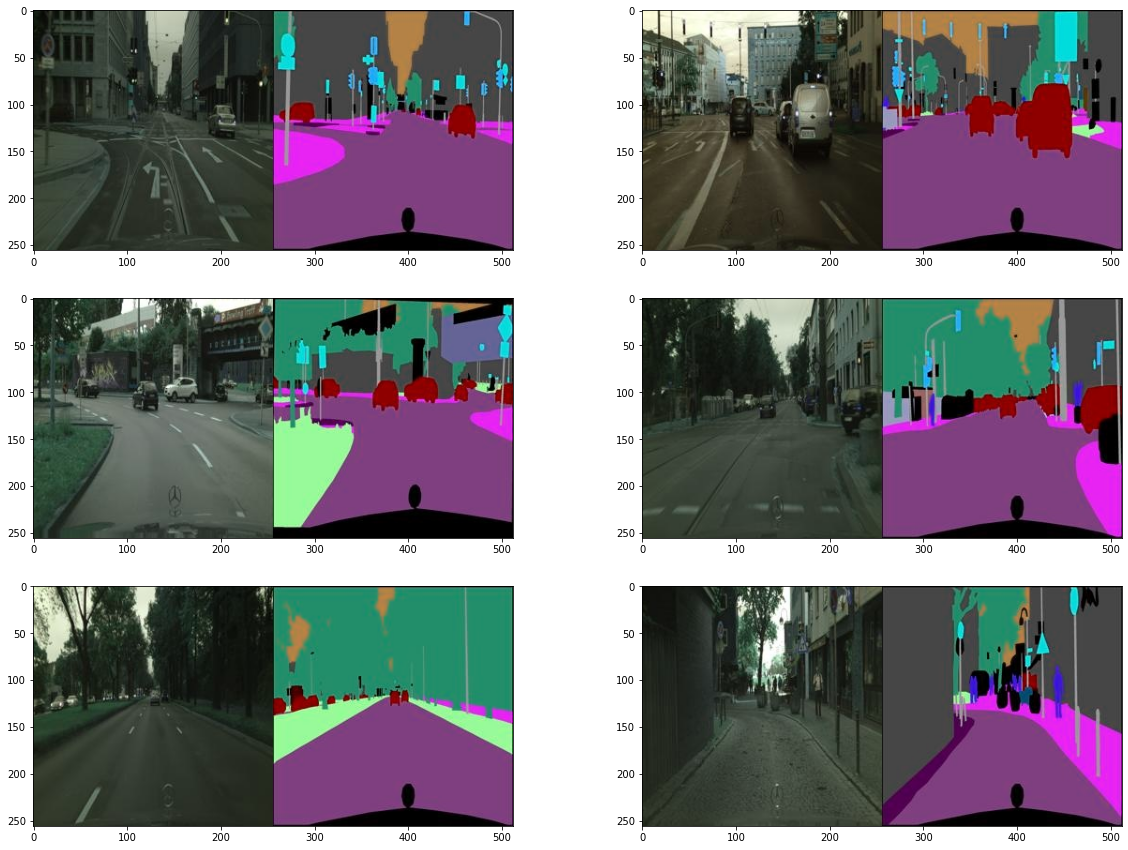

In [3]:
import numpy
import tensorflow

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

# training data에서 임의로 6장을 선택해 시각화
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR: 이미지를 컬러로 로드해 투명한 부분은 모두 무시
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0] # 첫 번째 이미지
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> (256, 256, 3) 크기의 2개 이미지로 분할해 사용하기.

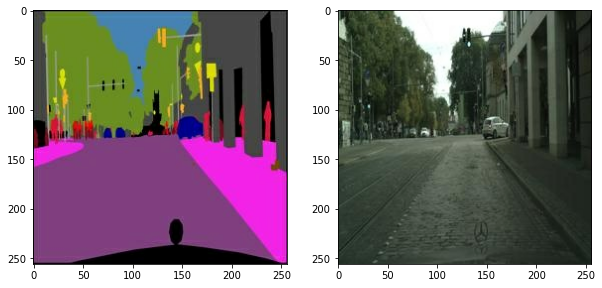

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1 # 정규화

def denormalize(x):
    x = (x+1) * 127.5 # 역정규화
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2 # 512 -> 256
    sketch = img[:, :w, :] # 변수명이 잘못되었다. (아래도 쭉) - 실질적으론 얘가 real image
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] # 얘가 sketch(input)
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1); plt.imshow(denormalize(colored))
plt.subplot(1, 2, 2); plt.imshow(denormalize(sketch))

## 2. Data Augmentation

데이터가 총 1000개뿐이므로 다양성을 높이기 위해 augmentation 기법을 사용한다.

> - sketch와 colored 이미지가 채널 축으로 연결되어 0.5의 확률로 reflection padding 또는 constant padding이 진행되는데 30 pixel의 pad width만큼 적용된다.
> - padding 진행 후 이미지는 (256, 256, 6)의 크기로 임의로 잘라진 뒤
> - 0.5의 확률로 좌우 / 상하 반전, 회전이 진행된다.

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]]) # 30 픽셀의 pad width만큼 적용
    if tf.random.uniform(()) < .5: # 50%의 확률
        padded = tf.pad(stacked, _pad, "REFLECT") # reflection padding
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # constant padding

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) # 좌우 반전
    out = image.random_flip_up_down(out) # 상하 반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전
    
    return out[..., :3], out[..., 3:]

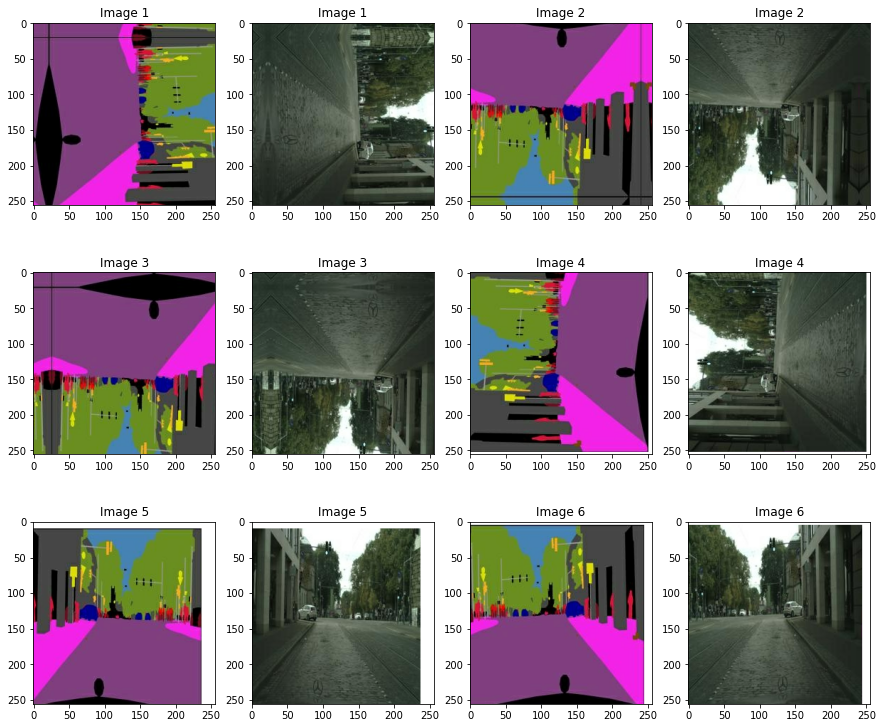

In [7]:
plt.figure(figsize=(15, 13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i);
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}") # input
    plt.subplot(3, 4, i+1)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}") # real
    img_n += 1

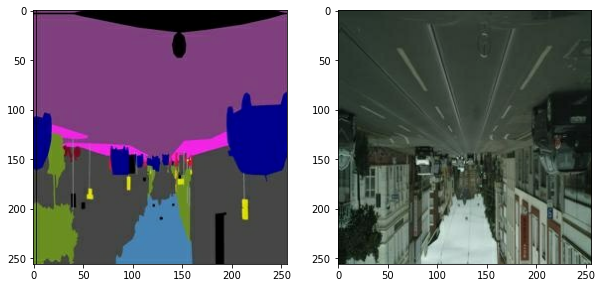

In [8]:
# 잘 적용 되었는지 하나의 이미지 시각화해 확인해보기
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4) # 1배치 당 4개의 데이터

sample = train_images.take(1) # take(): 해당 배치를 몇 번 불러올 건지
sample = list(sample.as_numpy_iterator()) # as_numpy_iterator(): 데이터의 모든 요소를 numpy로 변환
sketch, colored = (sample[0][0] + 1)*127.5, (sample[0][1] + 1)*127.5 # 역정규화

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1, 2, 2); plt.imshow(sketch[0].astype(np.uint8))

## 3. Generator
이 중에서도 Encoder & Decoder 간 skip connection이 있는 **U-Net Generator**를 사용하자.

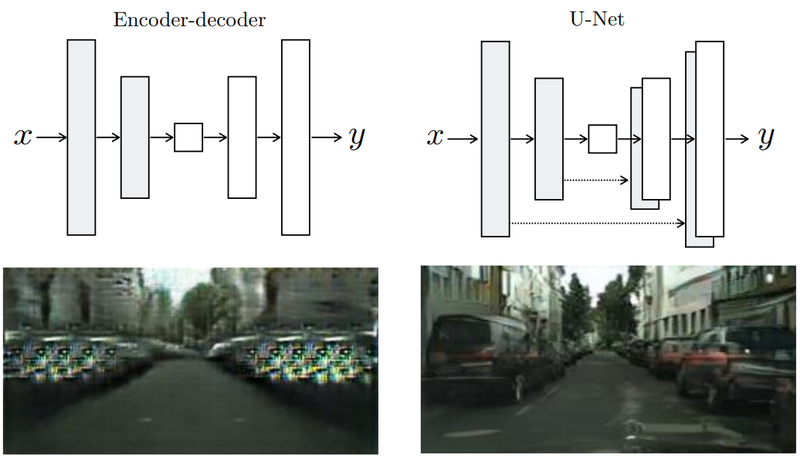

In [9]:
# Encoder, Decoder에서 사용되는 기본적인 블록

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

#### 🌱  `U-Net Generator` 정의

In [10]:
# U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        # Encoder 및 Decoder 내부 연산 수행
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # for 'skip connection'
        for block in self.encode_blocks:
            x = block(x)
            features.append(x) # Encoder에서 사용된 각 블록들의 출력 담음
        
        features = features[:-1] # 마지막 Encoder의 출력은 Decoder로 직접 입력되므로
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

> `__init__()` : Encoder 및 Decoder 에서 사용할 모든 블록 정의
> - `encode_blocks`, `decode_blocks`
> - Encoder 및 Decoder의 내부 연산 수행

> `call()`: forward propagation
> - **skip connection**을 위해 `features`라는 리스트를 만들어 Encoder에서 사용된 각 블록들의 출력을 담는다.
> - Encoder의 최종 출력이 Decoder의 입력으로 들어가는데, features에 담긴 각 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 들어감

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

> skip connection으로 인해 Decoder의 각 블록에서 입력 받는 채널의 수 증가
> - convolution 레이어에서 사용하는 필터의 크기가 커지며 학습할 파라미터 수 증가

## 4. Discriminator

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [13]:
inputs = Input((128, 128, 32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


> 이런식으로 (width, height)의 크기를 1씩 감소시킬 수 있다.

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

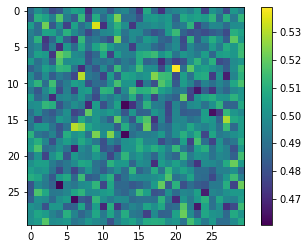

In [16]:
# 시험삼아 임의의 (256, 256, 3)의 입력을 넣어 나오는 (30, 30) 출력 시각화 하기
x = tf.random.normal([1, 256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

> 위 (30, 30) 크기의 결과 이미지의 각 픽셀 값은 원래 입력의 (70, 70) 패치에 대한 분류 결과
> - 전체 입력의 크기가 (256, 256)이므로 각 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있을 것임
> - 각 픽셀의 결괏값은 sigmoid의 결괏값이므로 0~1 사이의 값을 가져 진짜 및 가짜 데이터를 판별해 내는데 사용됨

## 5. 모델 학습

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

**✔️ Generator의 손실 함수: `gen_gene_loss`** <br/>
- **`fake_disct`**: Generator가 생성한 가짜 이미지를 Discriminator에 입력해 얻은 값
- L1-loss를 계산하기 위해 생성한 가짜 이미지(**`fake_output`**)와 실제 이미지(**`real_output`**) 사이의 MAE 계산

<br/>

**✔️ Discriminator의 손실 함수: `get_disc_loss`** <br/>
- **`fake_disc`, `real_disc`**: 가짜 및 진짜 이미지가 Discriminator에 입력되어 가각 얻어진 값
- Discrimiator은 실제 이미지를 잘 구분해야 하므로 `real_disc`는 1로 채워진 벡터와, `fake_disc`는 0으로 채워진 벡터와 비교

In [18]:
from tensorflow.keras import optimizers

# 논문과 동일하게 optimizer 설정
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gene_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gene_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.7700                     
L1_loss:0.2507                     
Discriminator_loss:0.5612

EPOCH[1] - STEP[100]                     
Generator_loss:2.7628                     
L1_loss:0.2336                     
Discriminator_loss:0.8278

EPOCH[1] - STEP[150]                     
Generator_loss:0.9900                     
L1_loss:0.2166                     
Discriminator_loss:0.8510

EPOCH[1] - STEP[200]                     
Generator_loss:1.4632                     
L1_loss:0.2155                     
Discriminator_loss:0.8035

EPOCH[1] - STEP[250]                     
Generator_loss:2.6842                     
L1_loss:0.2119                     
Discriminator_loss:0.8336

EPOCH[2] - STEP[50]                     
Generator_loss:1.7339                     
L1_loss:0.2202                     
Discriminator_loss:0.5299

EPOCH[2] - STEP[100]                     
Generator_loss:3.3804                     
L1_loss:0.2414               

EPOCH[12] - STEP[100]                     
Generator_loss:4.4694                     
L1_loss:0.1396                     
Discriminator_loss:0.9322

EPOCH[12] - STEP[150]                     
Generator_loss:2.1937                     
L1_loss:0.1570                     
Discriminator_loss:0.4771

EPOCH[12] - STEP[200]                     
Generator_loss:1.7208                     
L1_loss:0.1679                     
Discriminator_loss:0.5385

EPOCH[12] - STEP[250]                     
Generator_loss:2.1822                     
L1_loss:0.2020                     
Discriminator_loss:1.8256

EPOCH[13] - STEP[50]                     
Generator_loss:2.8914                     
L1_loss:0.1783                     
Discriminator_loss:0.6249

EPOCH[13] - STEP[100]                     
Generator_loss:1.2434                     
L1_loss:0.1700                     
Discriminator_loss:0.9449

EPOCH[13] - STEP[150]                     
Generator_loss:2.0166                     
L1_loss:0.1400       

EPOCH[23] - STEP[150]                     
Generator_loss:1.3675                     
L1_loss:0.2006                     
Discriminator_loss:0.4339

EPOCH[23] - STEP[200]                     
Generator_loss:0.8661                     
L1_loss:0.1082                     
Discriminator_loss:1.4519

EPOCH[23] - STEP[250]                     
Generator_loss:2.9359                     
L1_loss:0.1870                     
Discriminator_loss:1.1683

EPOCH[24] - STEP[50]                     
Generator_loss:2.0379                     
L1_loss:0.1609                     
Discriminator_loss:0.8752

EPOCH[24] - STEP[100]                     
Generator_loss:2.1009                     
L1_loss:0.1839                     
Discriminator_loss:0.2156

EPOCH[24] - STEP[150]                     
Generator_loss:2.0379                     
L1_loss:0.1667                     
Discriminator_loss:0.3767

EPOCH[24] - STEP[200]                     
Generator_loss:0.8168                     
L1_loss:0.1464       

EPOCH[34] - STEP[200]                     
Generator_loss:2.7928                     
L1_loss:0.1619                     
Discriminator_loss:0.2152

EPOCH[34] - STEP[250]                     
Generator_loss:2.5547                     
L1_loss:0.1370                     
Discriminator_loss:2.0479

EPOCH[35] - STEP[50]                     
Generator_loss:2.9360                     
L1_loss:0.1719                     
Discriminator_loss:0.1314

EPOCH[35] - STEP[100]                     
Generator_loss:1.2050                     
L1_loss:0.1508                     
Discriminator_loss:0.7972

EPOCH[35] - STEP[150]                     
Generator_loss:2.4902                     
L1_loss:0.1521                     
Discriminator_loss:0.5409

EPOCH[35] - STEP[200]                     
Generator_loss:1.9154                     
L1_loss:0.1126                     
Discriminator_loss:0.5433

EPOCH[35] - STEP[250]                     
Generator_loss:0.9800                     
L1_loss:0.1556       

EPOCH[45] - STEP[250]                     
Generator_loss:0.9112                     
L1_loss:0.1545                     
Discriminator_loss:0.7238

EPOCH[46] - STEP[50]                     
Generator_loss:1.6885                     
L1_loss:0.1766                     
Discriminator_loss:0.3420

EPOCH[46] - STEP[100]                     
Generator_loss:0.9871                     
L1_loss:0.1345                     
Discriminator_loss:2.4677

EPOCH[46] - STEP[150]                     
Generator_loss:2.6500                     
L1_loss:0.1543                     
Discriminator_loss:0.2010

EPOCH[46] - STEP[200]                     
Generator_loss:1.5403                     
L1_loss:0.1666                     
Discriminator_loss:0.3680

EPOCH[46] - STEP[250]                     
Generator_loss:1.3716                     
L1_loss:0.1677                     
Discriminator_loss:0.4291

EPOCH[47] - STEP[50]                     
Generator_loss:3.3278                     
L1_loss:0.1285        

EPOCH[57] - STEP[50]                     
Generator_loss:2.6710                     
L1_loss:0.1334                     
Discriminator_loss:0.4101

EPOCH[57] - STEP[100]                     
Generator_loss:1.8196                     
L1_loss:0.1756                     
Discriminator_loss:0.4383

EPOCH[57] - STEP[150]                     
Generator_loss:1.6904                     
L1_loss:0.1463                     
Discriminator_loss:0.5581

EPOCH[57] - STEP[200]                     
Generator_loss:2.0482                     
L1_loss:0.1487                     
Discriminator_loss:0.2324

EPOCH[57] - STEP[250]                     
Generator_loss:2.7553                     
L1_loss:0.1612                     
Discriminator_loss:0.2910

EPOCH[58] - STEP[50]                     
Generator_loss:1.4850                     
L1_loss:0.1716                     
Discriminator_loss:0.5174

EPOCH[58] - STEP[100]                     
Generator_loss:1.9332                     
L1_loss:0.1210        

EPOCH[68] - STEP[100]                     
Generator_loss:2.6310                     
L1_loss:0.1478                     
Discriminator_loss:0.4622

EPOCH[68] - STEP[150]                     
Generator_loss:4.5759                     
L1_loss:0.1875                     
Discriminator_loss:0.3259

EPOCH[68] - STEP[200]                     
Generator_loss:2.1415                     
L1_loss:0.1543                     
Discriminator_loss:0.3283

EPOCH[68] - STEP[250]                     
Generator_loss:2.3310                     
L1_loss:0.1292                     
Discriminator_loss:0.2872

EPOCH[69] - STEP[50]                     
Generator_loss:4.1604                     
L1_loss:0.1548                     
Discriminator_loss:0.0816

EPOCH[69] - STEP[100]                     
Generator_loss:5.4195                     
L1_loss:0.1248                     
Discriminator_loss:0.7106

EPOCH[69] - STEP[150]                     
Generator_loss:2.9866                     
L1_loss:0.1281       

EPOCH[79] - STEP[150]                     
Generator_loss:4.1541                     
L1_loss:0.1322                     
Discriminator_loss:0.1210

EPOCH[79] - STEP[200]                     
Generator_loss:2.4154                     
L1_loss:0.1148                     
Discriminator_loss:0.1632

EPOCH[79] - STEP[250]                     
Generator_loss:4.5014                     
L1_loss:0.1341                     
Discriminator_loss:0.3400

EPOCH[80] - STEP[50]                     
Generator_loss:3.6450                     
L1_loss:0.1141                     
Discriminator_loss:0.4248

EPOCH[80] - STEP[100]                     
Generator_loss:2.5552                     
L1_loss:0.1223                     
Discriminator_loss:0.3216

EPOCH[80] - STEP[150]                     
Generator_loss:2.7889                     
L1_loss:0.1496                     
Discriminator_loss:0.1400

EPOCH[80] - STEP[200]                     
Generator_loss:4.6043                     
L1_loss:0.1755       

EPOCH[90] - STEP[200]                     
Generator_loss:1.1437                     
L1_loss:0.1289                     
Discriminator_loss:0.7651

EPOCH[90] - STEP[250]                     
Generator_loss:1.2736                     
L1_loss:0.1460                     
Discriminator_loss:0.7236

EPOCH[91] - STEP[50]                     
Generator_loss:5.3632                     
L1_loss:0.1308                     
Discriminator_loss:0.9768

EPOCH[91] - STEP[100]                     
Generator_loss:2.2712                     
L1_loss:0.1235                     
Discriminator_loss:0.4464

EPOCH[91] - STEP[150]                     
Generator_loss:2.2579                     
L1_loss:0.1178                     
Discriminator_loss:0.4147

EPOCH[91] - STEP[200]                     
Generator_loss:2.8964                     
L1_loss:0.1295                     
Discriminator_loss:0.1647

EPOCH[91] - STEP[250]                     
Generator_loss:1.7331                     
L1_loss:0.1770       

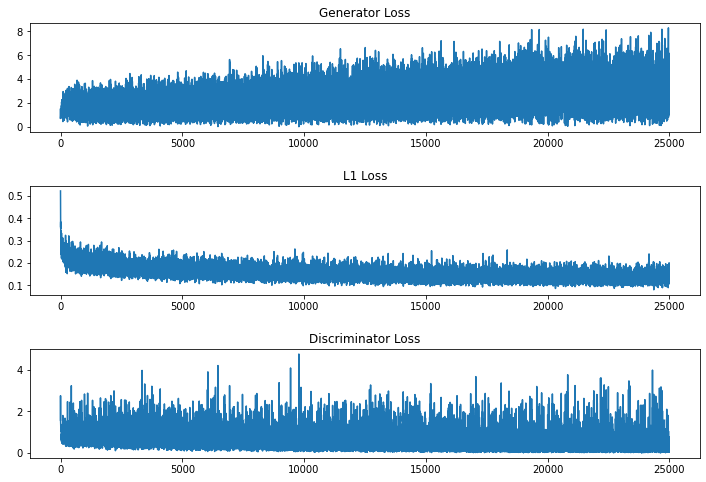

In [26]:
# Loss 시각화
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(history['gene_loss'])
plt.title('Generator Loss')

plt.subplot(3, 1, 2)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(3, 1, 3)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.subplots_adjust(hspace=0.5)
plt.show()

## 6. 테스트
- `val` 폴더 내 이미지 이용하기

In [21]:
test_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/val/'

test_len = len(os.listdir(test_path))
print("number of test examples :", test_len)

number of test examples : 5


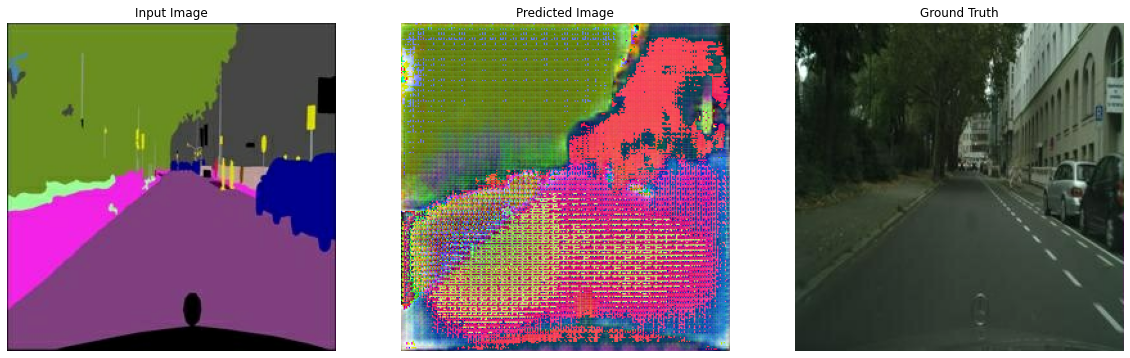

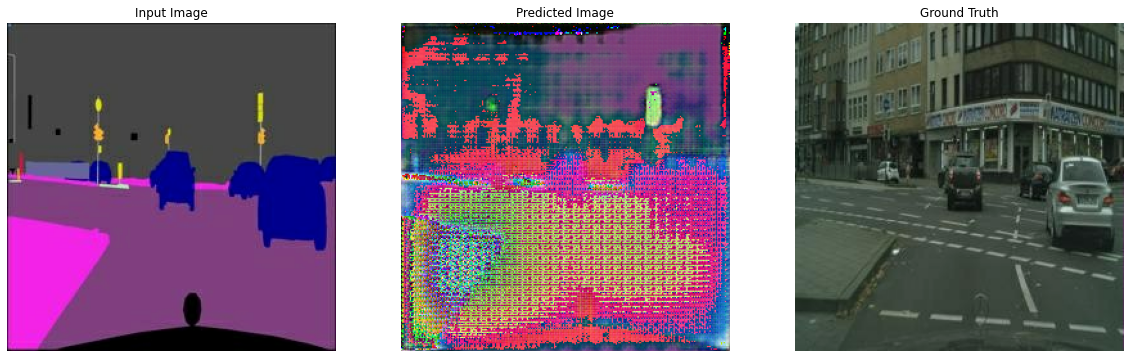

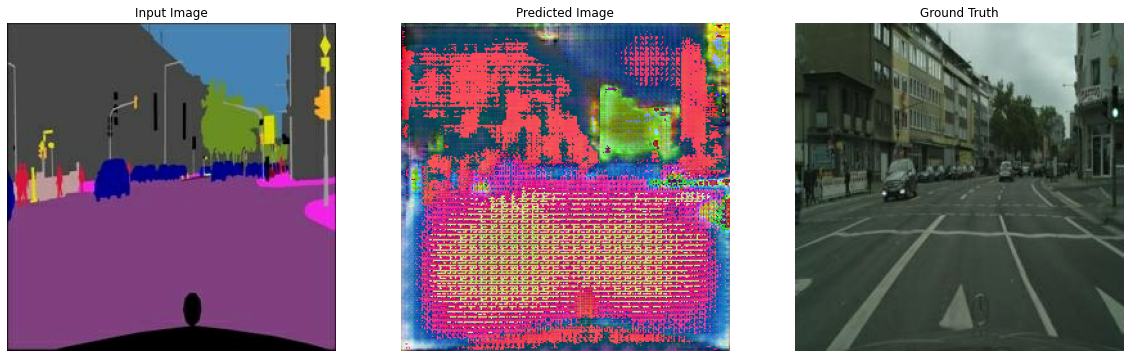

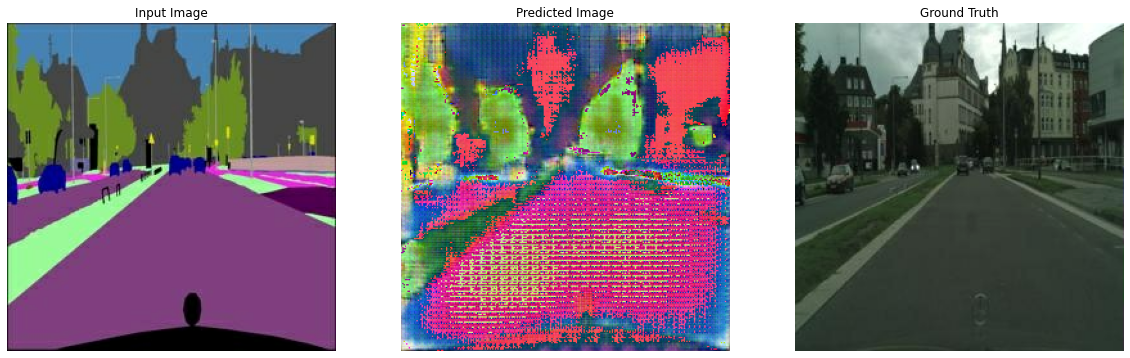

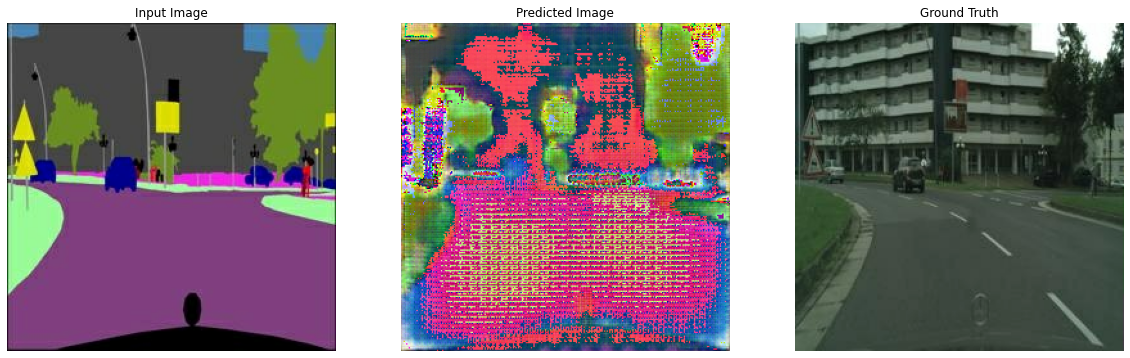

In [23]:
for i in range(test_len):
    f = data_path + os.listdir(test_path)[i]
    real, sketch = load_img(f)
    
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1);
    plt.axis('off')
    plt.imshow(denormalize(sketch)); plt.title('Input Image');
    plt.subplot(1, 3, 2);
    plt.axis('off')
    plt.imshow(pred[0]); plt.title('Predicted Image');
    plt.subplot(1, 3, 3);
    plt.axis('off')
    plt.imshow(denormalize(real)); plt.title('Ground Truth');

***

### 🥕 추가 실습 - optimizer 변경
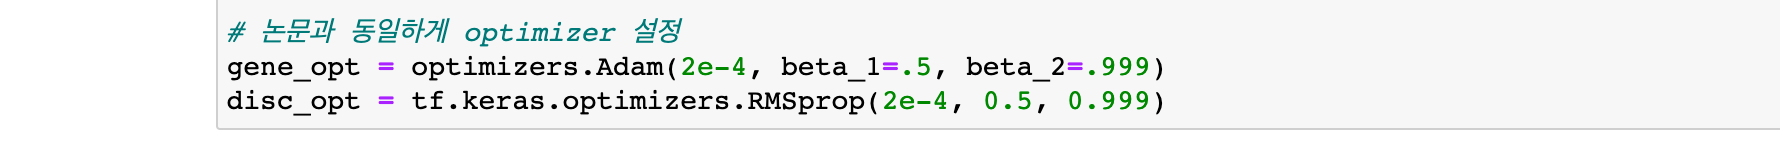

- 지난번 GAN 노드에서 discriminator의 optimizer을 RMSprop으로 바꾸었을 때 성능이 더 좋게 나와 변경해보았지만, 아래 loss 값 그래프를 보면 비교도 안 될만큼 크게 나왔다.

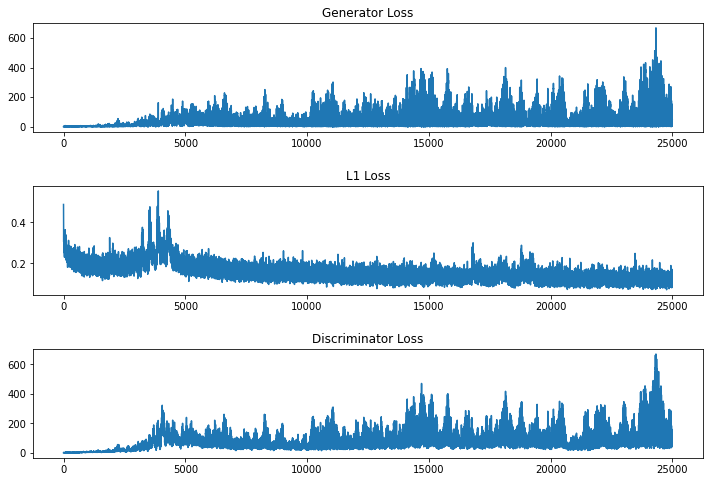
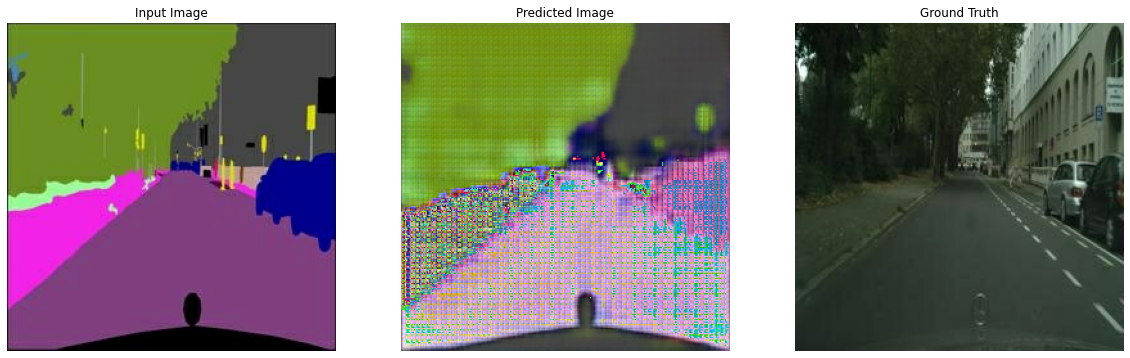
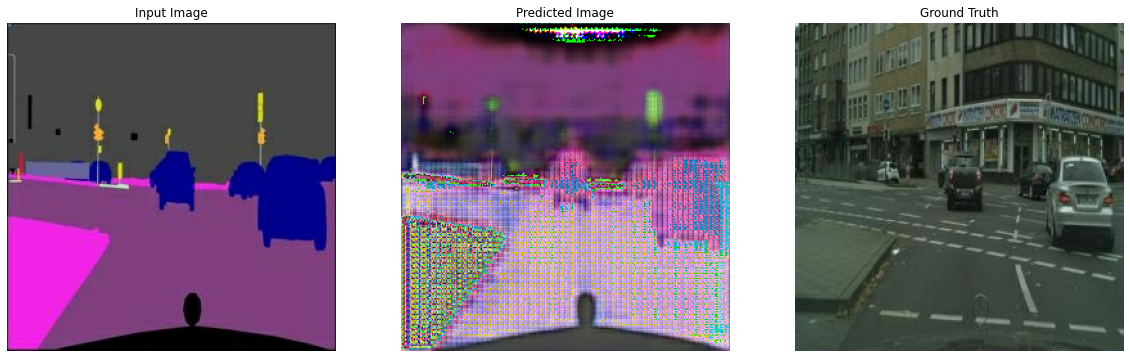
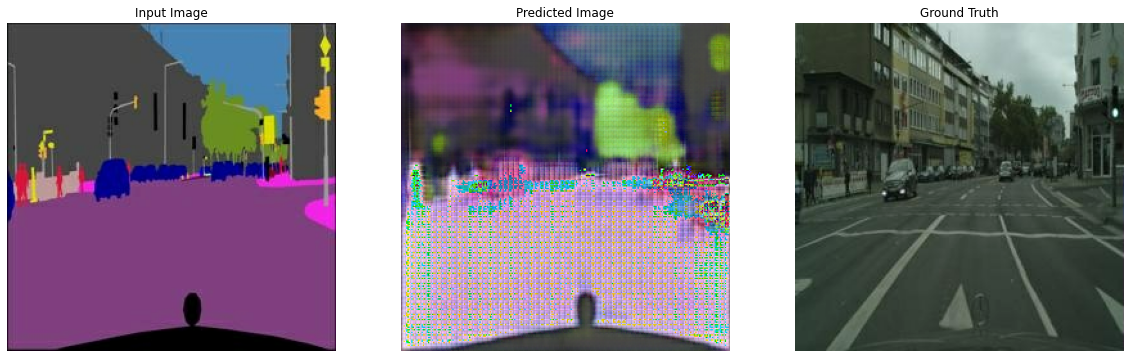
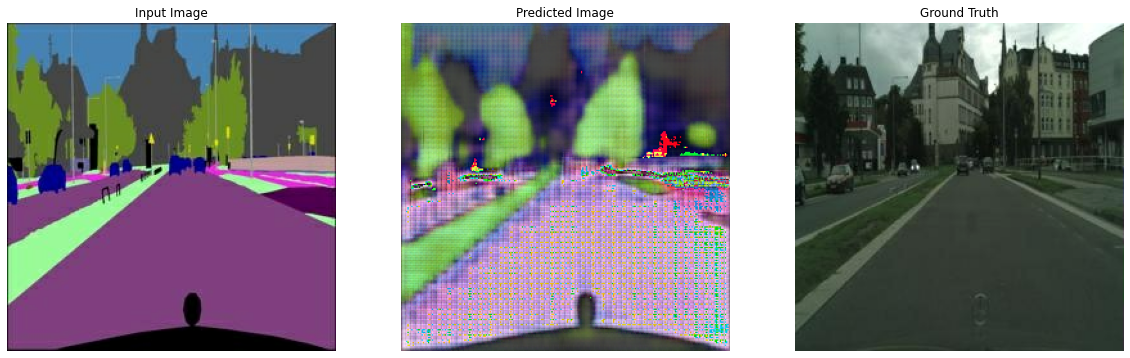
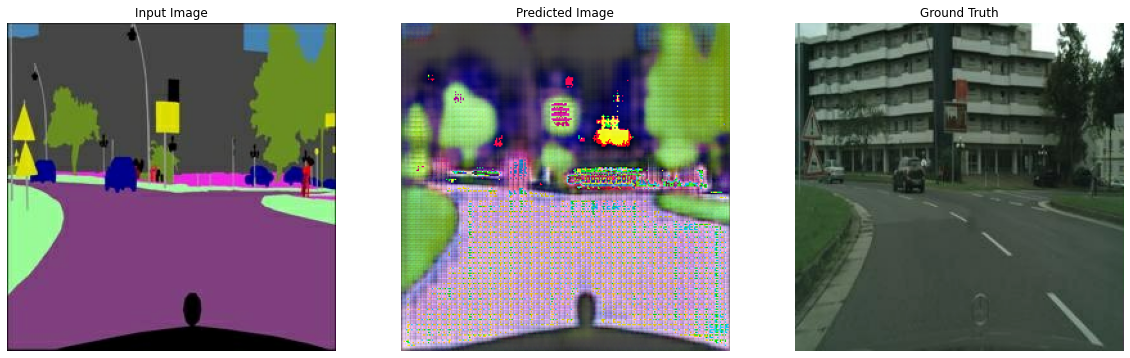

***

## 🧤 회고
- 충분히 학습되어야 좋은 결과 이미지를 보일 것 같아 호기롭게 처음부터 500 epoch를 돌렸더니 총 6시간이 걸렸다 .. 그런데도 눈에 띄게 좋은 성능을 보이지는 않았다.
- 모델이 안정적으로 수렴하지 못했다는 것으로 생각된다. 시간 관계상 더 들여다보지 못했다.
- 테스트 단계에서 input image와 ground truth가 뒤바껴 순서를 바꿔 보여주는 부분이 좀 헷갈렸다.
- epoch를 수정하려 다시 실행하면 train_step 부분에서 에러가 떠서 처음부터 재실행해주는 번거로움이 발생했다. 이유가 궁금하다.